In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import time
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE


## Increase size of jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"));

In [2]:
# Get directories
notebooks_dir = os.path.abspath(os.path.dirname('__file__'))
base_dir = os.path.dirname(os.path.join(notebooks_dir))
data_dir = os.path.join(base_dir,'data')
raw_data_dir =  os.path.join(data_dir,'raw')
processed_data_dir = os.path.join(data_dir,'processed')

In [15]:
# import custom utilities
sys.path.append(os.path.join(base_dir,'utils'))
import utils 

In [3]:
# Import the transformed data
raw_data = os.path.join(processed_data_dir,'loan_tape_processed.csv')
raw_df = pd.read_csv(raw_data,index_col=0)

In [4]:
raw_df.columns

Index(['amount', 'negbalancerate', 'brigitloansrepaid', 'accthistorydays',
       'noactivityrate', 'recurringrate', 'debitcountz', 'debitamountz',
       'dayswithbrigit', 'balance', 'dailydebitcountmean',
       'credittodebitratiomean', 'highestpaydepositvoladj', 'dailyincomemean',
       'recurrentcount', 'negbaleventcount', 'dailydebitcountsd',
       'daystopayday', 'monthswithfeesrate', 'highestpaymonthage',
       'default_flag', 'balancemeanCombined', 'payFreq__BIWEEKLY',
       'payFreq__IRREGULAR', 'payFreq__MONTHLY', 'payFreq__MONTHLY_WEEKDAY',
       'payFreq__SEMIMONTHLY', 'payFreq__Unknown', 'payFreq__WEEKLY',
       'signUpSource__ANDROID', 'signUpSource__IOS', 'signUpSource__MOBILE',
       'signUpSource__Unknown', 'signUpSource__WEB', 'signUpState__AK',
       'signUpState__AL', 'signUpState__AR', 'signUpState__AZ',
       'signUpState__CA', 'signUpState__CO', 'signUpState__CT',
       'signUpState__DC', 'signUpState__DE', 'signUpState__FL',
       'signUpState__GA', 

### Transform data, set up train test splits, & Over Sample

In [5]:
## Create Train Test splits
X = raw_df.drop(['default_flag'],axis=1).reset_index(drop=True)
y = raw_df['default_flag']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0, stratify=y)
columns = X_train.columns

## Over sample our training set
over_sample = SMOTE(random_state=0)
over_sample_data_X, over_sample_data_y = over_sample.fit_sample(X_train, y_train)
over_sample_data_X = pd.DataFrame(data=over_sample_data_X,columns=columns )
over_sample_data_y = pd.DataFrame(data=over_sample_data_y,columns=['y'])

X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(over_sample_data_X,over_sample_data_y,test_size=0.2, random_state=0, stratify=over_sample_data_y)

print("length of oversampled data is ",len(over_sample_data_X))
print("Number of no default in oversampled data",len(over_sample_data_y[over_sample_data_y['y']==0]))
print("Number of default",len(over_sample_data_y[over_sample_data_y['y']==1]))
print("Proportion of no default data in oversampled data is ",len(over_sample_data_y[over_sample_data_y['y']==0])/len(over_sample_data_X))
print("Proportion of default data in oversampled data is ",len(over_sample_data_y[over_sample_data_y['y']==1])/len(over_sample_data_X))

length of oversampled data is  427628
Number of no default in oversampled data 213814
Number of default 213814
Proportion of no default data in oversampled data is  0.5
Proportion of default data in oversampled data is  0.5


## First, I want to train a model on the interesting data points from my data exploration

In [6]:
interesting_columns = [
    'negbalancerate',
    'brigitloansrepaid',
    'accthistorydays',
    'noactivityrate',
    'dayswithbrigit',
    'recurrentcount',
    'highestpaymonthage',
    'payFreq__BIWEEKLY',
    'payFreq__IRREGULAR', 
    'payFreq__MONTHLY',
    'payFreq__MONTHLY_WEEKDAY',
    'payFreq__SEMIMONTHLY', 
    'payFreq__Unknown', 
    'payFreq__WEEKLY',
    'daystopayday',
    'dailydebitcountmean',
    'monthswithfeesrate',
    
]

### Run a statsmodel to quickly see if the p value on any variable is out of order

In [7]:
import statsmodels.api as sm
logit_model=sm.Logit(y_os_train,X_os_train[interesting_columns])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.635250
         Iterations 6
                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.084      
Dependent Variable:     y                  AIC:                434674.7593
Date:                   2019-06-29 22:39   BIC:                434857.3880
No. Observations:       342102             Log-Likelihood:     -2.1732e+05
Df Model:               16                 LL-Null:            -2.3713e+05
Df Residuals:           342085             LLR p-value:        0.0000     
Converged:              1.0000             Scale:              1.0000     
No. Iterations:         6.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
negbalancerate            0.

In [8]:
## payFreq__SEMIMONTHLY and payFreq__BIWEEKLY  have very high p values. Ill drop semi monthly
interesting_columns.remove('payFreq__SEMIMONTHLY')
import statsmodels.api as sm
logit_model=sm.Logit(y_os_train,X_os_train[interesting_columns])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.635250
         Iterations 6
                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.084      
Dependent Variable:     y                  AIC:                434672.9142
Date:                   2019-06-29 22:39   BIC:                434844.8000
No. Observations:       342102             Log-Likelihood:     -2.1732e+05
Df Model:               15                 LL-Null:            -2.3713e+05
Df Residuals:           342086             LLR p-value:        0.0000     
Converged:              1.0000             Scale:              1.0000     
No. Iterations:         6.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
negbalancerate            0.

### Looks good now.

### Run a gridsearch to tune the hyper parameters

In [9]:
logreg_init = LogisticRegression(solver='lbfgs',max_iter=500)

## 
params = {'C':np.linspace(.1,1,10)}
gs_init = GridSearchCV(logreg_init,params,cv=5,verbose=True,n_jobs=6)
gs_init.fit(X_os_train[interesting_columns],y_os_train['y'].ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.4min finished
C:\Users\richard\.conda\envs\brigit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=6,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

### Fit logreg using best estimator from GridSearch

In [10]:
logreg_init = LogisticRegression(C=gs_init.best_estimator_.C,solver='lbfgs',max_iter=500)
logreg_init.fit(X_os_train[interesting_columns],y_os_train['y'])

C:\Users\richard\.conda\envs\brigit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Get overall accuracy of initial model

In [11]:
y_pred_init_train = logreg_init.predict(X_os_test[interesting_columns])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_init.score(X_os_test[interesting_columns], y_os_test['y'])))

Accuracy of logistic regression classifier on test set: 0.63


### Classification Report For Initial Model

In [12]:
print(classification_report(y_os_test['y'], y_pred_init_train))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62     42763
           1       0.63      0.66      0.64     42763

    accuracy                           0.63     85526
   macro avg       0.63      0.63      0.63     85526
weighted avg       0.63      0.63      0.63     85526



### Coefficients for initial log reg model

In [13]:
coefs = pd.DataFrame(logreg_init.coef_,columns=X_os_test[interesting_columns].columns,index=['Coefficients']).T.sort_values(by='Coefficients')
coefs

,Coefficients
payFreq__WEEKLY,-0.352681
brigitloansrepaid,-0.203496
monthswithfeesrate,-0.173139
recurrentcount,-0.123959
payFreq__BIWEEKLY,-0.112686
accthistorydays,-0.002952
dayswithbrigit,0.003275
daystopayday,0.003630
dailydebitcountmean,0.027086
payFreq__MONTHLY_WEEKDAY,0.027959


### Plot ROC AUC curve for my initial model

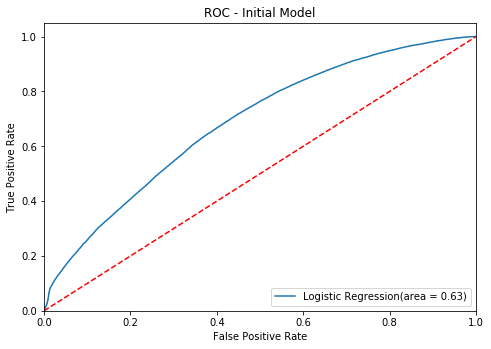

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax)
ax.set_title('ROC - Initial Model');

## Finally, how does this model perform on the final hold out set?

### Get overall accuracy of initial model on hold out data

In [17]:
y_pred_init_test = logreg_init.predict(X_test[interesting_columns])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_init.score(X_test[interesting_columns], y_test)))

Accuracy of logistic regression classifier on test set: 0.61


### Classification Report For Initial Model on holdout data

In [18]:
print(classification_report(y_test, y_pred_init_test))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     53454
           1       0.18      0.65      0.28      7120

    accuracy                           0.61     60574
   macro avg       0.55      0.63      0.51     60574
weighted avg       0.84      0.61      0.68     60574



In [19]:
init_tn, init_fp, init_fn, init_tp = confusion_matrix(y_test,y_pred_init_test).ravel()
# Get total sample size
init_n = init_tn+init_fp+init_fn+init_tp

init_balanced_accuracy = ((init_tp/init_n)+ (init_tn/init_n))/2 # see https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_Data
print('Balanced Accuracy Score: {:0.4f}'.format(init_balanced_accuracy))

Balanced Accuracy Score: 0.3075


### Plot initial model ROC AUC for hold out set and compare to training data

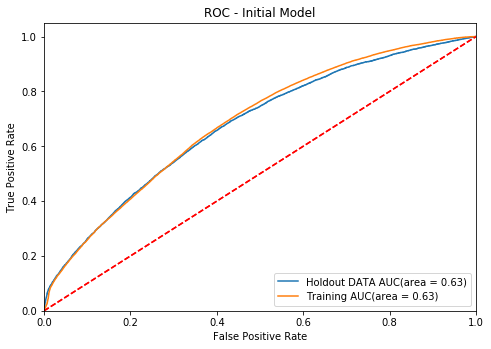

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_test[interesting_columns],y_test=y_test,y_pred=y_pred_init_test,model=logreg_init,ax=ax, label='Holdout DATA AUC')
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax, label='Training AUC')
ax.set_title('ROC - Initial Model');

### Now that I have a benchmark to work from, let's see if we can improve this score. I'll start with a recursive feature elimination to see if we can pick better features.

<a name="RFE Training"></a>
## Train model from RFE features

In [21]:
data_final_vars=raw_df.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression(solver='liblinear',max_iter=300)

rfe = RFE(logreg, 14,)
rfe = rfe.fit(over_sample_data_X, over_sample_data_y.values.ravel())

### Run a statsmodel to quickly see if the p value on any variable is out of order

In [22]:
logit_model = sm.Logit(y_os_train,X_os_train[columns[rfe.support_]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.660929
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.046      
Dependent Variable:  y                 AIC:               452238.4218
Date:                2019-06-30 07:35  BIC:               452388.8219
No. Observations:    342102            Log-Likelihood:    -2.2611e+05
Df Model:            13                LL-Null:           -2.3713e+05
Df Residuals:        342088            LLR p-value:       0.0000     
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      6.0000                                          
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
noactivityrate        1.7429   0.0269  64.8052 0.0000  1.6901  1.7956
recurringrate   

### P-Values seem to be inline let's move on to the grid search

In [23]:
logreg = LogisticRegression(solver='lbfgs',max_iter=500)

## 
params = {'C':np.linspace(.1,1,10)}
gs_rfe = GridSearchCV(logreg,params,cv=5,verbose=True,n_jobs=6)
gs_rfe.fit(X_os_train[columns[rfe.support_]],y_os_train['y'].ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   39.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=6,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [24]:
logreg = LogisticRegression(C=gs_rfe.best_estimator_.C,solver='liblinear',max_iter=500)
logreg.fit(X_os_train[columns[rfe.support_]],y_os_train['y'])

LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_pred_rfe_train = logreg.predict(X_os_test[columns[rfe.support_]])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_os_test[columns[rfe.support_]], y_os_test['y'])))

Accuracy of logistic regression classifier on test set: 0.59


### The accuracy is similar but slightly lower than my original model. What do the other metrics say?

### Coefficients for RFE trainged log reg model

In [29]:
coefs_rfe = pd.DataFrame(logreg.coef_,columns=X_os_test[columns[rfe.support_]].columns,index=['Coefficients']).T.sort_values(by='Coefficients')
coefs_rfe

,Coefficients
recurringrate,-3.615070
payFreq__WEEKLY,-0.918948
payFreq__BIWEEKLY,-0.620831
payFreq__SEMIMONTHLY,-0.582769
debitcountz,-0.440086
signUpSource__MOBILE,-0.400149
signUpState__MI,0.409600
signUpState__AK,0.439911
signUpState__MO,0.450581
debitamountz,0.467104


### Classification Report For RFE trained model

In [31]:
print(classification_report(y_os_test['y'], y_pred_rfe_train))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62     42763
           1       0.61      0.52      0.56     42763

    accuracy                           0.59     85526
   macro avg       0.59      0.59      0.59     85526
weighted avg       0.59      0.59      0.59     85526



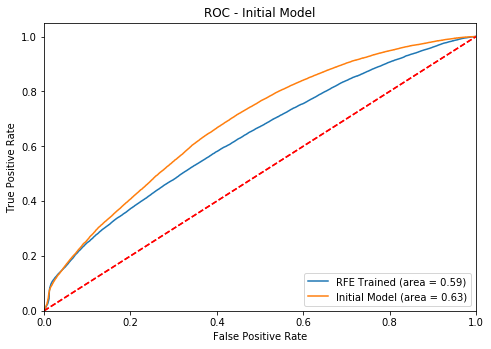

In [33]:
## RFE VS Initial Model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_os_test[columns[rfe.support_]],y_test=y_os_test['y'],y_pred=y_pred_rfe_train,model=logreg,ax=ax,label='RFE Trained ')
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax,label='Initial Model ')
ax.set_title('ROC - Initial Model');

### The initial model outperforms the RFE model on the training dataset. How do the two compare against the hold out data set?

In [34]:
y_pred_rfe_test = logreg.predict(X_test[columns[rfe.support_]])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test[columns[rfe.support_]], y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [35]:
print(classification_report(y_test, y_pred_rfe_test))

              precision    recall  f1-score   support

           0       0.91      0.66      0.76     53454
           1       0.17      0.51      0.25      7120

    accuracy                           0.64     60574
   macro avg       0.54      0.58      0.51     60574
weighted avg       0.82      0.64      0.70     60574



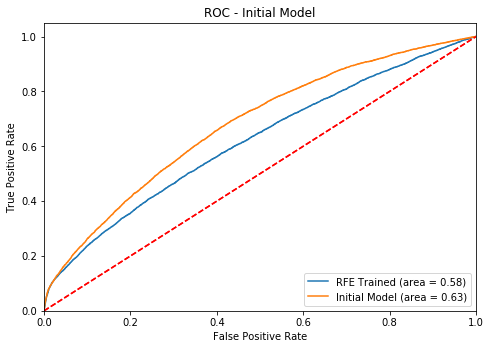

In [38]:
## RFE test holdout set VS Initial Model holdout set
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_test[columns[rfe.support_]],y_test=y_test,y_pred=y_pred_rfe_test,model=logreg,ax=ax,label='RFE Trained ')
ax = utils.roc_auc_plot(x_test=X_test[interesting_columns],y_test=y_test,y_pred=y_pred_init_test,model=logreg_init,ax=ax,label='Initial Model ')
ax.set_title('ROC - Initial Model');

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_rfe_test).ravel()
# Get total sample size
n = tn+fp+fn+tp

balanced_accuracy1 = ((tp/n)+ (tn/n))/2
print('Balanced Accuracy Score: {:0.4f}'.format(balanced_accuracy1))

Balanced Accuracy Score: 0.3205


### Although the initial model outperforms by a AUC metric, it underperforms in the balanced accuracy score. Lets compare the scores:

#### AUC: RFE .58, init .63
#### Balanced Accuracy: RFE .32, init .30
#### Precision (Default): RFE .17, init .18
#### Recall (Default): RFE .51, init .64
#### F1-Score (Default): RFE .25, init  .28

### Since these two models are so close in score, I'm going to iterate on the init model. The features it provides give us more information on the user's behavior vs using location as a decision factor

## Try a new feature

### Since bad behavior (negative balance rate and such) provide an indicator that a loan may default, can we engineer a new feature that will strengthen our model?

In [40]:
raw_df['days_negative_balance'] = raw_df['negbalancerate']*(raw_df['accthistorydays'])

In [41]:
import copy
new_interesting_columns = copy.deepcopy(interesting_columns)
new_interesting_columns.append('days_negative_balance')

In [42]:
## Create Train Test splits
X = raw_df.drop(['default_flag'],axis=1).reset_index(drop=True)
y = raw_df['default_flag']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0, stratify=y)
columns = X_train.columns

## Over sample our training set
over_sample = SMOTE(random_state=0)
over_sample_data_X, over_sample_data_y = over_sample.fit_sample(X_train, y_train)
over_sample_data_X = pd.DataFrame(data=over_sample_data_X,columns=columns )
over_sample_data_y = pd.DataFrame(data=over_sample_data_y,columns=['y'])

X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(over_sample_data_X,over_sample_data_y,test_size=0.2, random_state=0, stratify=over_sample_data_y)

print("length of oversampled data is ",len(over_sample_data_X))
print("Number of no subscription in oversampled data",len(over_sample_data_y[over_sample_data_y['y']==0]))
print("Number of subscription",len(over_sample_data_y[over_sample_data_y['y']==1]))
print("Proportion of no default data in oversampled data is ",len(over_sample_data_y[over_sample_data_y['y']==0])/len(over_sample_data_X))
print("Proportion of default data in oversampled data is ",len(over_sample_data_y[over_sample_data_y['y']==1])/len(over_sample_data_X))

length of oversampled data is  427628
Number of no subscription in oversampled data 213814
Number of subscription 213814
Proportion of no default data in oversampled data is  0.5
Proportion of default data in oversampled data is  0.5


In [43]:
logit_model=sm.Logit(y_os_train,X_os_train[new_interesting_columns])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.635970
         Iterations 6
                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.082      
Dependent Variable:     y                  AIC:                435166.9292
Date:                   2019-06-30 07:42   BIC:                435349.5578
No. Observations:       342102             Log-Likelihood:     -2.1757e+05
Df Model:               16                 LL-Null:            -2.3713e+05
Df Residuals:           342085             LLR p-value:        0.0000     
Converged:              1.0000             Scale:              1.0000     
No. Iterations:         6.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
negbalancerate            0.

### Use GS to find ideal hyperparameters

In [45]:
logreg_init_1 = LogisticRegression(solver='liblinear',max_iter=500)

## 
params = {'C':np.linspace(.1,1,10)}
gs_init_1 = GridSearchCV(logreg_init_1,params,cv=5,verbose=True,n_jobs=8)
gs_init_1.fit(X_os_train[new_interesting_columns],y_os_train['y'].ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [46]:
logreg_init_1 = LogisticRegression(C=gs_init_1.best_estimator_.C,solver='liblinear',max_iter=500)
logreg_init_1.fit(X_os_train[new_interesting_columns],y_os_train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred_init1_train = logreg_init_1.predict(X_os_test[new_interesting_columns])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_init_1.score(X_os_test[new_interesting_columns], y_os_test['y'])))

Accuracy of logistic regression classifier on test set: 0.63


In [48]:
print(classification_report(y_os_test['y'], y_pred_init1_train))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62     42763
           1       0.63      0.65      0.64     42763

    accuracy                           0.63     85526
   macro avg       0.63      0.63      0.63     85526
weighted avg       0.63      0.63      0.63     85526



In [49]:
coefs = pd.DataFrame(logreg_init_1.coef_,columns=X_os_test[new_interesting_columns].columns,index=['Coefficients']).T.sort_values(by='Coefficients')
coefs

,Coefficients
payFreq__WEEKLY,-0.257563
brigitloansrepaid,-0.202523
monthswithfeesrate,-0.166715
recurrentcount,-0.127947
payFreq__BIWEEKLY,-0.044779
accthistorydays,-0.001870
days_negative_balance,-0.001346
dayswithbrigit,0.003226
daystopayday,0.005567
highestpaymonthage,0.026581


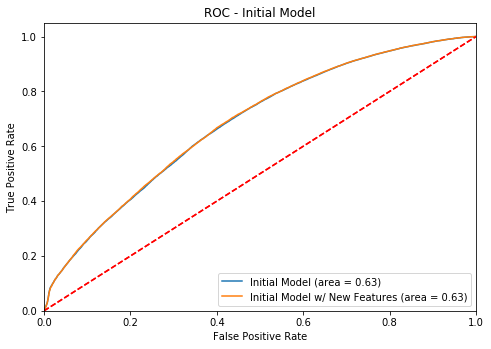

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax,label='Initial Model ')
ax = utils.roc_auc_plot(x_test=X_os_test[new_interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init1_train,model=logreg_init_1,ax=ax,label='Initial Model w/ New Features ')
ax.set_title('ROC - Initial Model');

## There was no difference in the training model. let's try every feature and see the results

In [51]:
drop_cols = ['signUpState__Unknown','payFreq__SEMIMONTHLY','signUpSource__Unknown'] ## Drop one of each dummy var to reduce collinearity
logit_model=sm.Logit(y_os_train,X_os_train.drop(drop_cols,axis=1)) 
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.632047
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.088      
Dependent Variable:    y                  AIC:                432614.9546
Date:                  2019-06-30 07:47   BIC:                433506.6123
No. Observations:      342102             Log-Likelihood:     -2.1622e+05
Df Model:              82                 LL-Null:            -2.3713e+05
Df Residuals:          342019             LLR p-value:        0.0000     
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        8.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
amount                    0.0018   0.000

In [52]:
### Drop columns with high p values
drop_cols.extend(['dailydebitcountmean',
                  'signUpState__AK',
                  'signUpState__DC',
                  'signUpState__MO',
                  'credittodebitratiomean',
                  'signUpState__DE',
                  'signUpState__SC',
                  'days_negative_balance',
                  'highestpaydepositvoladj']) ## Drop variables with > .1 p score
logit_model=sm.Logit(y_os_train,X_os_train.drop(drop_cols,axis=1)) 
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.632061
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.088      
Dependent Variable:    y                  AIC:                432606.7477
Date:                  2019-06-30 07:47   BIC:                433401.7197
No. Observations:      342102             Log-Likelihood:     -2.1623e+05
Df Model:              73                 LL-Null:            -2.3713e+05
Df Residuals:          342028             LLR p-value:        0.0000     
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
amount                    0.0019   0.000

### GS at the model with all features

In [53]:
logreg_init_2 = LogisticRegression(solver='liblinear',max_iter=500)

## 
params = {'C':np.linspace(.1,1,10)}
gs_init_2 = GridSearchCV(logreg_init_2,params,cv=5,verbose=True,n_jobs=8)
gs_init_2.fit(X_os_train.drop(drop_cols,axis=1),y_os_train['y'].ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  8.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [54]:
## Fit with best C value
logreg_init_2 = LogisticRegression(C=gs_init_2.best_estimator_.C,solver='liblinear',max_iter=500)
logreg_init_2.fit(X_os_train.drop(drop_cols,axis=1),y_os_train['y'])

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred_all_features_train = logreg_init_2.predict(X_os_test.drop(drop_cols,axis=1))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_init_2.score(X_os_test.drop(drop_cols,axis=1), y_os_test['y'])))

Accuracy of logistic regression classifier on test set: 0.64


### Classification Report

In [56]:
print(classification_report(y_os_test['y'], y_pred_all_features_train))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     42763
           1       0.63      0.65      0.64     42763

    accuracy                           0.64     85526
   macro avg       0.64      0.64      0.64     85526
weighted avg       0.64      0.64      0.64     85526



### Coefs

In [57]:
coefs = pd.DataFrame(logreg_init_2.coef_,columns=X_os_test.drop(drop_cols,axis=1).columns,index=['Coefficients']).T.sort_values(by='Coefficients')
coefs

,Coefficients
recurringrate,-0.852516
debitcountz,-0.582409
signUpState__NY,-0.260494
signUpState__UT,-0.253572
signUpState__CO,-0.236680
signUpState__CT,-0.233068
payFreq__WEEKLY,-0.221451
brigitloansrepaid,-0.205946
signUpState__WV,-0.182777
signUpState__AZ,-0.175556


### AUC

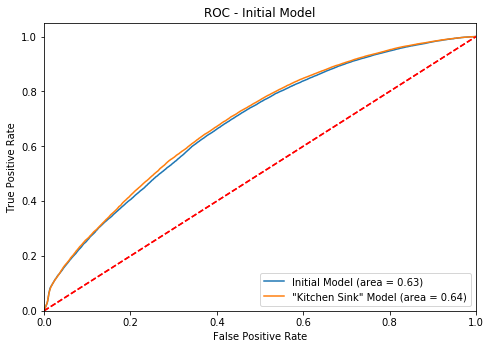

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax,label='Initial Model ')
ax = utils.roc_auc_plot(x_test=X_os_test.drop(drop_cols,axis=1),y_test=y_os_test['y'],y_pred=y_pred_all_features_train,model=logreg_init_2,ax=ax,label='"Kitchen Sink" Model ')
ax.set_title('ROC - Initial Model');

In [59]:
y_pred_all_features_test = logreg_init_2.predict(X_test.drop(drop_cols,axis=1))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_init_2.score(X_test.drop(drop_cols,axis=1), y_pred_all_features_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [60]:
### Precision and AUC vs holdout data
print(classification_report(y_test, y_pred_all_features_test))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74     53454
           1       0.18      0.64      0.29      7120

    accuracy                           0.62     60574
   macro avg       0.56      0.63      0.51     60574
weighted avg       0.84      0.62      0.69     60574



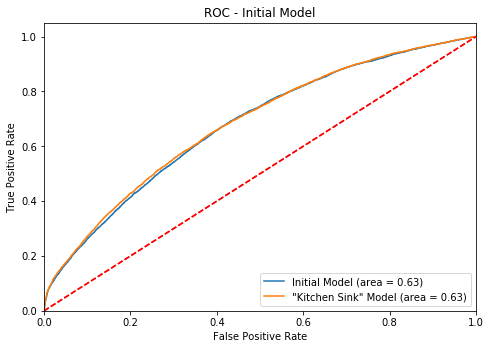

In [61]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_test[interesting_columns],y_test=y_test,y_pred=y_pred_init_test,model=logreg_init,ax=ax,label='Initial Model ')
ax = utils.roc_auc_plot(x_test=X_test.drop(drop_cols,axis=1),y_test=y_test,y_pred=y_pred_all_features_test,model=logreg_init_2,ax=ax,label='"Kitchen Sink" Model ')
ax.set_title('ROC - Initial Model');

### No Difference. Next let's try a Random Forest Classifier

In [62]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [64]:
rfc = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 9)
# Fit the random search model
rf_random.fit(X_os_train[new_interesting_columns],y_os_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed: 95.3min
[Parallel(n_jobs=9)]: Done 144 tasks      | elapsed: 377.4min
[Parallel(n_jobs=9)]: Done 300 out of 300 | elapsed: 738.3min finished
C:\Users\richard\.conda\envs\brigit\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [65]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

### Fit RFC to new features

In [68]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rfc = RandomForestClassifier(**rf_random.best_params_) ## Unpack the best params into the classifier
rfc.fit(X_os_train[new_interesting_columns],y_os_train['y'])

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Let's check out the best parameters

In [71]:
rfc.score(X_os_train[new_interesting_columns],y_os_train['y'])

0.999979538266365

In [72]:
y_pred_rfc_train = rfc.predict(X_os_train[new_interesting_columns])

In [73]:
### Precision and AUC vs holdout data
print(classification_report(y_os_train['y'], y_pred_rfc_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    171051
           1       1.00      1.00      1.00    171051

    accuracy                           1.00    342102
   macro avg       1.00      1.00      1.00    342102
weighted avg       1.00      1.00      1.00    342102



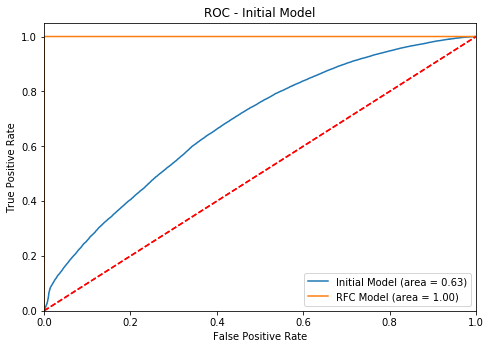

In [74]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_os_test[interesting_columns],y_test=y_os_test['y'],y_pred=y_pred_init_train,model=logreg_init,ax=ax, label='Initial Model ')
ax = utils.roc_auc_plot(x_test=X_os_train[new_interesting_columns],y_test=y_os_train['y'],y_pred=y_pred_rfc_train,model=rfc,ax=ax,label='RFC Model ')
ax.set_title('ROC - Initial Model');

### How does it perform on the hold out data?

In [76]:
rfc.score(X_test[new_interesting_columns],y_test)

0.8810215604054545

In [80]:
y_pred_rfc_test = rfc.predict(X_test[new_interesting_columns])

In [81]:
### Precision and AUC vs holdout data
print(classification_report(y_test, y_pred_rfc_test))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     53454
           1       0.45      0.06      0.10      7120

    accuracy                           0.88     60574
   macro avg       0.67      0.52      0.52     60574
weighted avg       0.84      0.88      0.84     60574



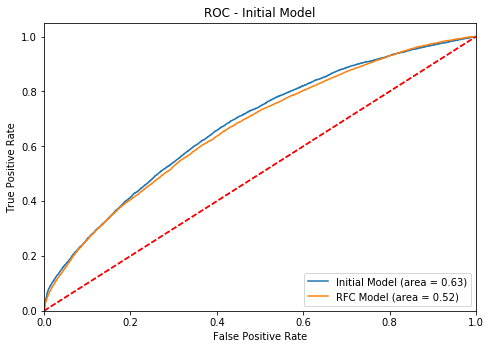

In [82]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = utils.roc_auc_plot(x_test=X_test[interesting_columns],y_test=y_test,y_pred=y_pred_init_test,model=logreg_init,ax=ax, label='Initial Model ')
ax = utils.roc_auc_plot(x_test=X_test[new_interesting_columns],y_test=y_test,y_pred=y_pred_rfc_test,model=rfc,ax=ax,label='RFC Model ')
ax.set_title('ROC - Initial Model');

In [ ]:
###